In [16]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix, lil_matrix
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from findiff import FinDiff, Identity, PDE, BoundaryConditions
import importlib

import linear

In [17]:
# Generate data from heat equation

# Set config params
grid_size = 50
time_size = 20
W_amp = 0

# Init fd = y = np.linspace(0, 1, grid_size)
t = np.linspace(0, 1, time_size)
x = np.linspace(0, 1, grid_size)
X, T = np.meshgrid(t, x, indexing='ij')
X_test = np.stack([T.flatten(), X.flatten()], axis=1)
shape = (time_size, grid_size)
dt = t[1]-t[0]
dx = x[1]-x[0]

In [18]:
# Set LHS
alpha = 0.05
diff_op = FinDiff(0, dt, 1) - alpha * FinDiff(1, dx, 2)

# Set RHS
np.random.seed(13)
W = W_amp * np.random.randn(*shape)

# Set boundary conditions (Dirichlet)
bc = BoundaryConditions(shape)
for i in range(grid_size):
    normal_pdf = np.exp(- ((x[i] - 0.5) / 0.1) ** 2)
    bc[0,i] = normal_pdf
bc[:,0] = 0
bc[:,-1] = 0

# Solve PDE
pde = PDE(diff_op, W, bc)
u = pde.solve()

In [19]:
# Set LHS
alpha = 0.05
diff_op = FinDiff(0, dt, 1) - alpha * FinDiff(1, dx, 2)

# Set RHS
np.random.seed(13)
W = W_amp * np.random.randn(*shape)

# Set boundary conditions (Dirichlet)
bc = BoundaryConditions(shape)
for i in range(grid_size):
    normal_pdf = 1 if (i > 20 and i < 30) else 0
    bc[0,i] = normal_pdf
bc[:,0] = 0
bc[:,-1] = 0

# Solve PDE
pde = PDE(diff_op, W, bc)
u_step = pde.solve()

Text(0.5, 1.0, 'Ground truth')

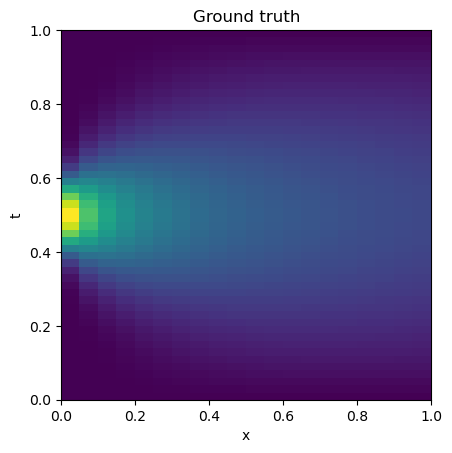

In [20]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
ax.imshow(u.T, extent=[0,1,1,0])
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Ground truth')

Text(0.5, 0.92, 'Smooth IC')

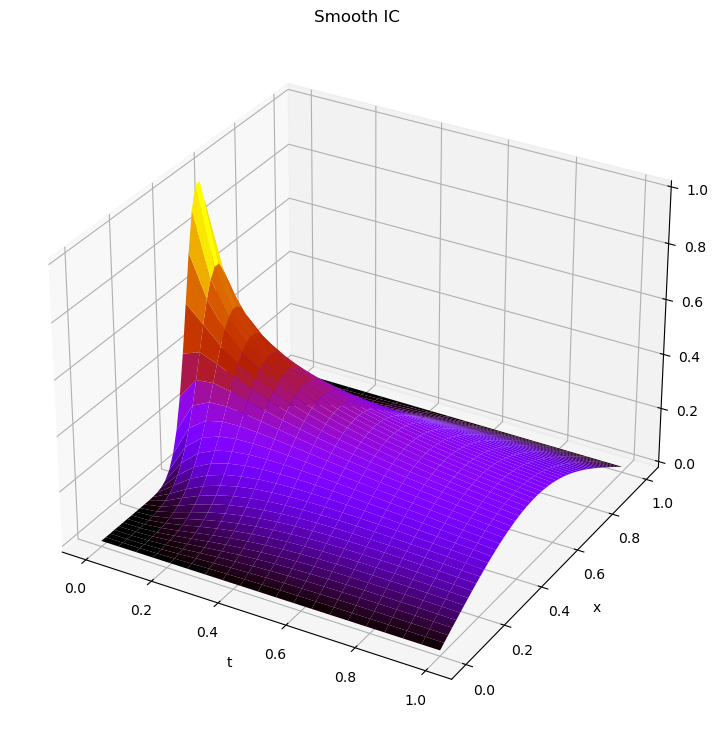

In [21]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,9))
surf = ax.plot_surface(X, T, u, cmap=cm.gnuplot)
ax.set_zlim([0,1])
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Smooth IC')
# fig.colorbar(surf)

Text(0.5, 0.92, 'Step IC')

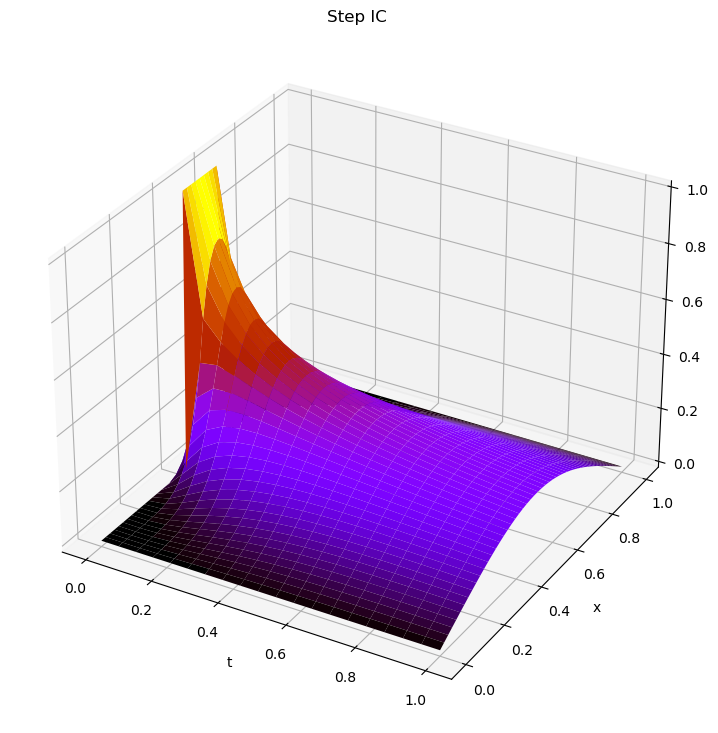

In [22]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,9))
surf = ax.plot_surface(X, T, u_step, cmap=cm.gnuplot)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Step IC')
# fig.colorbar(surf)

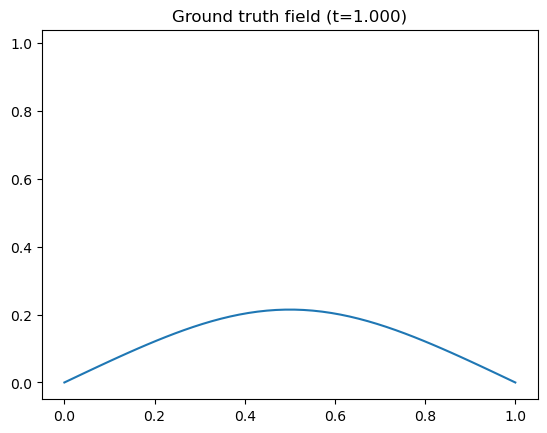

In [23]:
# Create animation
fig = plt.figure()
ax = plt.axes()
# ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
line, = ax.plot(x, u[0])

def animate(i):
    line.set_ydata(u[i])
    ax.set_title(f'Ground truth field (t={(dt*i):02.3f})')
    return line,

anim = animation.FuncAnimation(fig, animate, frames=time_size, interval=100, blit=True)
HTML(anim.to_jshtml())

In [24]:
obs_noise = 1e-4
obs_count = 100
obs_dict = linear.sample_observations(u_step, obs_count, obs_noise)
obs_idxs = np.array(list(obs_dict.keys()), dtype=int)

In [25]:
import jax


In [26]:
importlib.reload(linear)
num_samples = 30
alpha_guesses = np.linspace(0.03, 0.06, 10)
mses_step = np.empty((alpha_guesses.shape[0], num_samples))
nlls_step = np.empty((alpha_guesses.shape[0], num_samples))
for j in range(num_samples):
    obs_dict = linear.sample_observations(u_step, obs_count, obs_noise)
    for i, alpha_guess in enumerate(alpha_guesses):
        diff_op_guess = FinDiff(0, dt, 1) - alpha_guess * FinDiff(1, dx, 2)
        posterior_mean_pde, posterior_std_pde, nll = linear.fit_pde_gp(u_step, obs_dict, X_test, dx, dt, obs_noise, diff_op_guess)
        mses_step[i, j] = linear.mse(u_step, posterior_mean_pde)
        nlls_step[i, j] = nll
        print(f'alpha={alpha_guess:.4f}, MSE={mses_step[i, j]:.5f}, NLL={nlls_step[i, j]:.5f}')

alpha=0.0300, MSE=0.00138, NLL=6241.36546
alpha=0.0333, MSE=0.00151, NLL=6324.02492
alpha=0.0367, MSE=0.00165, NLL=6399.41712
alpha=0.0400, MSE=0.00176, NLL=6468.73013
alpha=0.0433, MSE=0.00185, NLL=6532.87544
alpha=0.0467, MSE=0.00192, NLL=6592.56981
alpha=0.0500, MSE=0.00197, NLL=6648.39001
alpha=0.0533, MSE=0.00202, NLL=6700.80825
alpha=0.0567, MSE=0.00205, NLL=6750.21614
alpha=0.0600, MSE=0.00205, NLL=6796.94193
alpha=0.0300, MSE=0.00110, NLL=6263.03079
alpha=0.0333, MSE=0.00105, NLL=6345.36928
alpha=0.0367, MSE=0.00102, NLL=6420.48103
alpha=0.0400, MSE=0.00101, NLL=6489.53337
alpha=0.0433, MSE=0.00104, NLL=6553.42918
alpha=0.0467, MSE=0.00111, NLL=6612.88610
alpha=0.0500, MSE=0.00126, NLL=6668.48443
alpha=0.0533, MSE=0.00149, NLL=6720.69823
alpha=0.0567, MSE=0.00177, NLL=6769.91868
alpha=0.0600, MSE=0.00206, NLL=6816.47260
alpha=0.0300, MSE=0.00146, NLL=6267.37618
alpha=0.0333, MSE=0.00133, NLL=6349.91484
alpha=0.0367, MSE=0.00127, NLL=6425.19724
alpha=0.0400, MSE=0.00126, NLL=649

In [27]:
importlib.reload(linear)
num_samples = 30
alpha_guesses = np.linspace(0.03, 0.06, 10)
mses_rbf = np.empty((alpha_guesses.shape[0], num_samples))
nlls_rbf = np.empty((alpha_guesses.shape[0], num_samples))
for j in range(num_samples):
    obs_dict = linear.sample_observations(u, obs_count, obs_noise)
    for i, alpha_guess in enumerate(alpha_guesses):
        diff_op_guess = FinDiff(0, dt, 1) - alpha_guess * FinDiff(1, dx, 2)
        posterior_mean_pde, posterior_std_pde, nll = linear.fit_pde_gp(u, obs_dict, X_test, dx, dt, obs_noise, diff_op_guess)
        mses_rbf[i, j] = linear.mse(u, posterior_mean_pde)
        nlls_rbf[i, j] = nll
        print(f'alpha={alpha_guess:.4f}, MSE={mses_rbf[i, j]:.5f}, NLL={nlls_rbf[i, j]:.5f}')

alpha=0.0300, MSE=0.00020, NLL=6267.00819
alpha=0.0333, MSE=0.00014, NLL=6348.95544
alpha=0.0367, MSE=0.00011, NLL=6423.68219
alpha=0.0400, MSE=0.00009, NLL=6492.37304
alpha=0.0433, MSE=0.00008, NLL=6555.94423
alpha=0.0467, MSE=0.00008, NLL=6615.11737
alpha=0.0500, MSE=0.00008, NLL=6670.46932
alpha=0.0533, MSE=0.00009, NLL=6722.46768
alpha=0.0567, MSE=0.00010, NLL=6771.49703
alpha=0.0600, MSE=0.00011, NLL=6817.87821
alpha=0.0300, MSE=0.00039, NLL=6268.65067
alpha=0.0333, MSE=0.00030, NLL=6350.84650
alpha=0.0367, MSE=0.00024, NLL=6425.80419
alpha=0.0400, MSE=0.00019, NLL=6494.70695
alpha=0.0433, MSE=0.00016, NLL=6558.46901
alpha=0.0467, MSE=0.00015, NLL=6617.81108
alpha=0.0500, MSE=0.00015, NLL=6673.31111
alpha=0.0533, MSE=0.00015, NLL=6725.43973
alpha=0.0567, MSE=0.00017, NLL=6774.58542
alpha=0.0600, MSE=0.00019, NLL=6821.07275
alpha=0.0300, MSE=0.00011, NLL=6257.76272
alpha=0.0333, MSE=0.00009, NLL=6340.32145
alpha=0.0367, MSE=0.00008, NLL=6415.61928
alpha=0.0400, MSE=0.00007, NLL=648

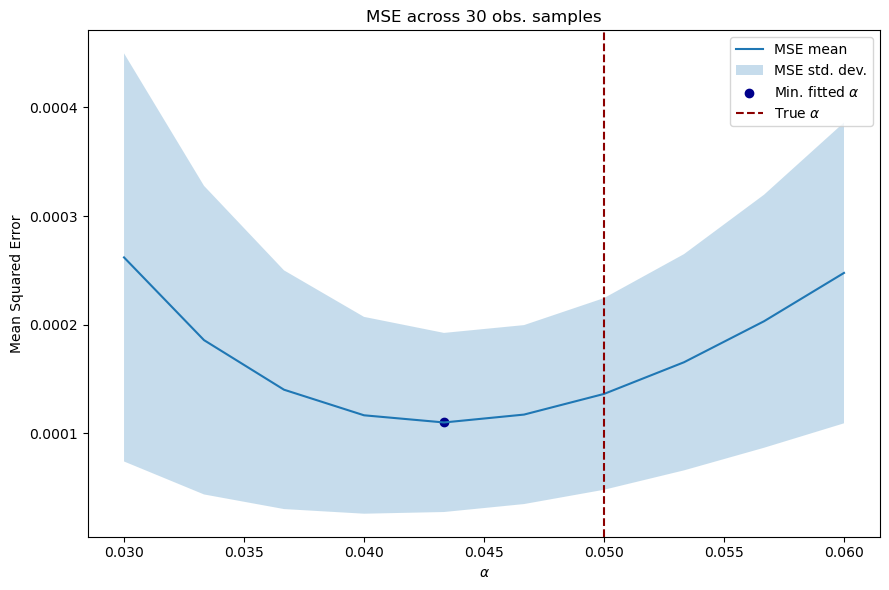

In [28]:
# mse_mean_step = mses_step.mean(axis=1)
# mse_std_step = mses_step.std(axis=1)
# min_alpha_step = alpha_guesses[np.argmin(mse_mean_step)]
mse_mean_rbf = mses_rbf.mean(axis=1)
mse_std_rbf = mses_rbf.std(axis=1)
min_alpha_rbf = alpha_guesses[np.argmin(mse_mean_rbf)]
# print(min_alpha_step, min_alpha_rbf)
plt.figure(figsize=(9,6))
# plt.plot(alpha_guesses, mse_mean_step, label=f"MSE mean")
# plt.fill_between(alpha_guesses, mse_mean_step + mse_std_step, mse_mean_step - mse_std_step, alpha=0.25, label=f"MSE std. dev.") 
# plt.scatter(min_alpha_step, np.min(mse_mean_step), color='darkblue', label="Min. fitted $\\alpha$")
plt.plot(alpha_guesses, mse_mean_rbf, label=f"MSE mean")
plt.fill_between(alpha_guesses, mse_mean_rbf + mse_std_rbf, mse_mean_rbf - mse_std_rbf, alpha=0.25, label=f"MSE std. dev.")
plt.scatter(min_alpha_rbf, np.min(mse_mean_rbf), color='darkblue', label="Min. fitted $\\alpha$")
plt.axvline(alpha, color='darkred', ls='--', label="True $\\alpha$")
plt.title(f"MSE across {num_samples} obs. samples")
plt.xlabel("$\\alpha$")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mse_alpha_smooth.png", dpi=200)
plt.show()

0.039999999999999994 0.039999999999999994


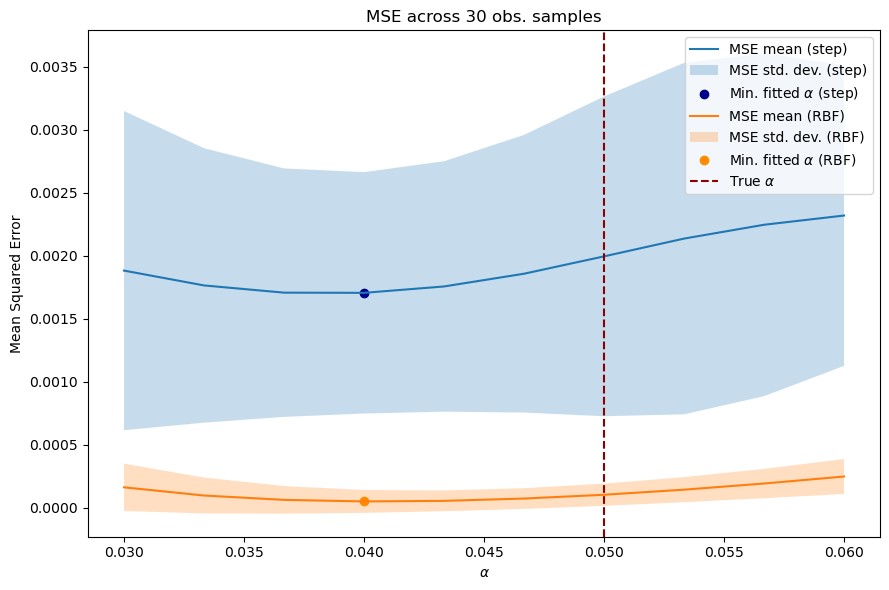

In [33]:
mse_mean_step = mses_step.mean(axis=1)
mse_std_step = mses_step.std(axis=1)
min_alpha_step = alpha_guesses[np.argmin(mse_mean_step)]
mse_mean_rbf = mses_rbf.mean(axis=1)
mse_std_rbf = mses_rbf.std(axis=1)
min_alpha_rbf = alpha_guesses[np.argmin(mse_mean_rbf)]
print(min_alpha_step, min_alpha_rbf)
plt.figure(figsize=(9,6))
plt.plot(alpha_guesses, mse_mean_step, label=f"MSE mean (step)")
plt.fill_between(alpha_guesses, mse_mean_step + mse_std_step, mse_mean_step - mse_std_step, alpha=0.25, label=f"MSE std. dev. (step)")
plt.scatter(min_alpha_step, np.min(mse_mean_step), color='darkblue', label="Min. fitted $\\alpha$ (step)")
plt.plot(alpha_guesses, mse_mean_rbf, label=f"MSE mean (RBF)")
plt.fill_between(alpha_guesses, mse_mean_rbf + mse_std_rbf, mse_mean_rbf - mse_std_rbf, alpha=0.25, label=f"MSE std. dev. (RBF)")
plt.scatter(min_alpha_rbf, np.min(mse_mean_rbf), color='darkorange', label="Min. fitted $\\alpha$ (RBF)")
plt.axvline(alpha, color='darkred', ls='--', label="True $\\alpha$")
plt.title(f"MSE across {num_samples} obs. samples")
plt.xlabel("$\\alpha$")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mse_alpha_step.png", dpi=200)
plt.show()

In [30]:
nll_mean = nlls.mean(axis=1)
nll_std = nlls.std(axis=1)
plt.plot(alpha_guesses, nll_mean, label=f"NLL mean")
plt.fill_between(alpha_guesses, nll_mean + nll_std, nll_mean - nll_std, alpha=0.25, label=f"NLL std. dev.")
plt.axvline(alpha, color='darkred', ls='--', label="True $\\alpha$")
plt.title(f"NLL across {num_samples} obs. samples")
plt.xlabel("$\\alpha$")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.savefig("figures/nll_alpha.png", dpi=200)
plt.show()

NameError: name 'nlls' is not defined

In [ ]:
obs_noise = 1e-4
obs_count = 100
obs_dict = linear.sample_observations(u_step, obs_count, obs_noise)
obs_idxs = np.array(list(obs_dict.keys()), dtype=int)

0.00010747947021777657
9.697345054616527e-05


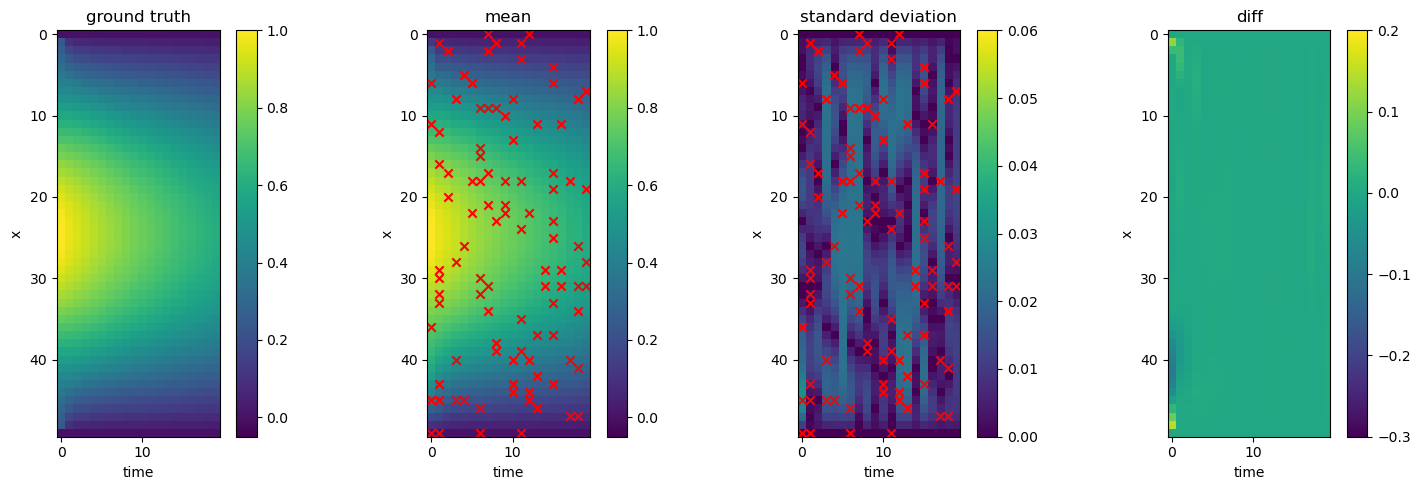

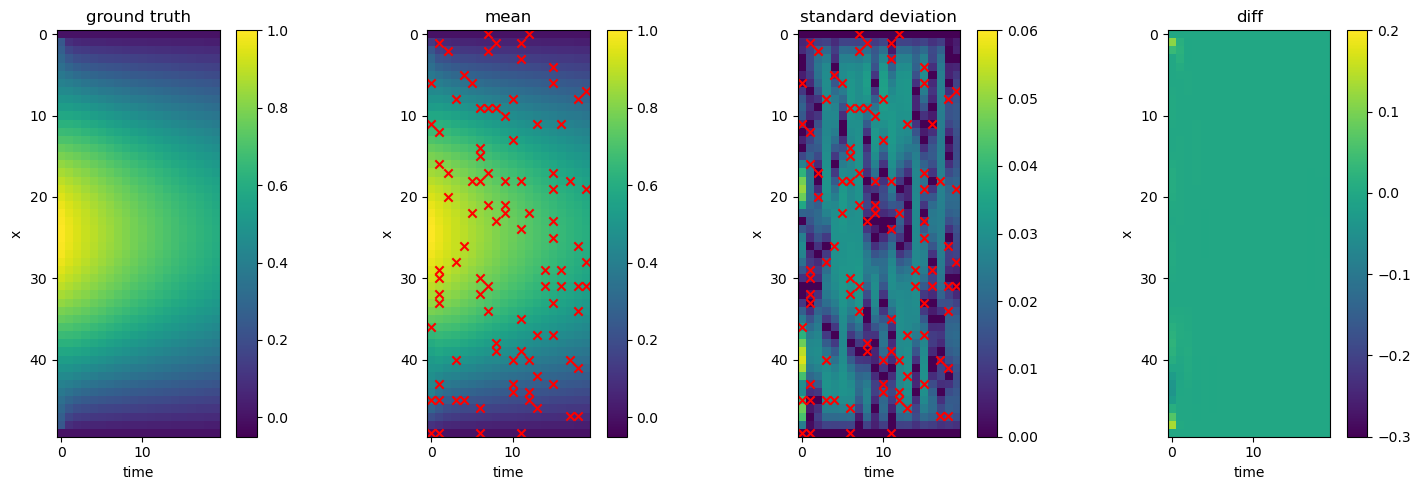

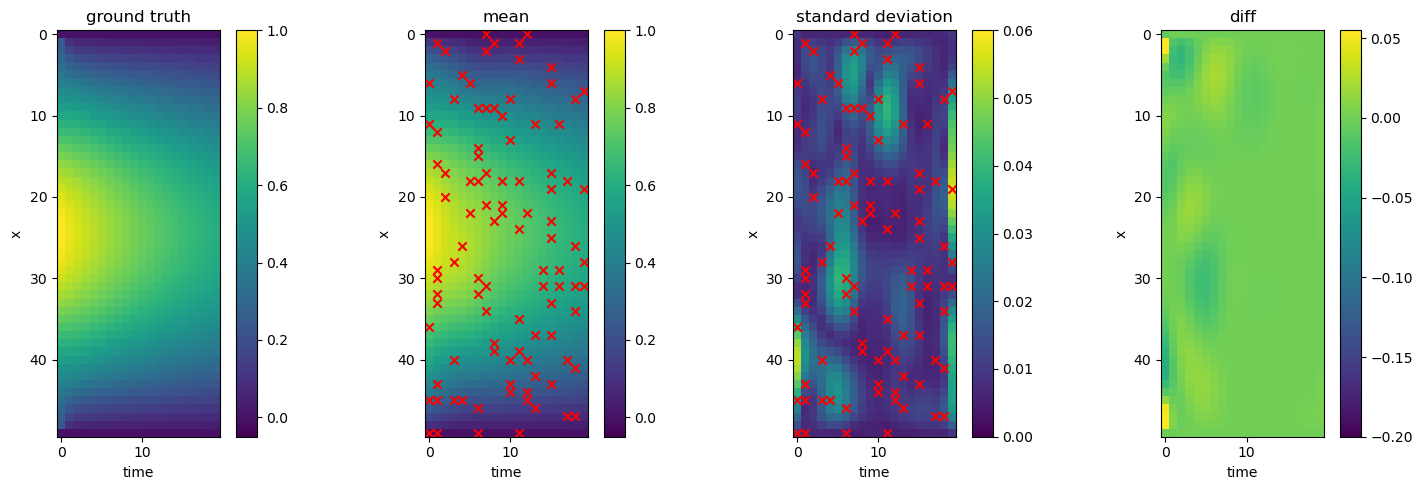

In [ ]:
diff_op_min = FinDiff(0, dt, 1) - min_alpha_rbf * FinDiff(1, dx, 2)
posterior_mean_pde, posterior_std_pde, _ = linear.fit_pde_gp(u, obs_dict, X_test, dx, dt, obs_noise, diff_op)
posterior_mean_min, posterior_std_min, _ = linear.fit_pde_gp(u, obs_dict, X_test, dx, dt, obs_noise, diff_op_min)
posterior_mean_rbf, posterior_std_rbf = linear.fit_rbf_gp(u, obs_dict, X_test, dx, dt, obs_noise)
print(linear.mse(u, posterior_mean_pde))
print(linear.mse(u, posterior_mean_rbf))
linear.plot_gp_2d(u.T, posterior_mean_pde.T, posterior_std_pde.T, linear.swap_cols(obs_idxs), 'figures/heat_eqn_test_pde.png',
                  mean_vmin=-0.05, mean_vmax=1, std_vmin=0, std_vmax=0.06,
                  diff_vmin=-0.3, diff_vmax=0.2)
linear.plot_gp_2d(u.T, posterior_mean_min.T, posterior_std_min.T, linear.swap_cols(obs_idxs), 'figures/heat_eqn_test_min.png',
                  mean_vmin=-0.05, mean_vmax=1, std_vmin=0, std_vmax=0.06,
                  diff_vmin=-0.3, diff_vmax=0.2)
linear.plot_gp_2d(u.T, posterior_mean_rbf.T, posterior_std_rbf.T, linear.swap_cols(obs_idxs), 'figures/heat_eqn_test_rbf.png',
                  mean_vmin=-0.05, mean_vmax=1, std_vmin=0, std_vmax=0.06, diff_vmin=-0.2, diff_vmax=0.055)

MovieWriter imagemagick unavailable; using Pillow instead.


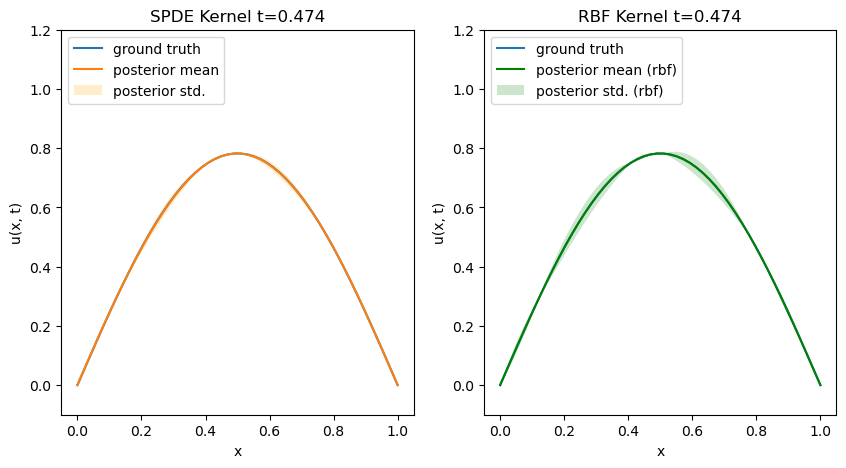

In [ ]:
importlib.reload(linear)
linear.create_HTML_animation(x, u, posterior_mean_pde, posterior_std_pde, posterior_mean_min, posterior_std_min, dt, "figures/heat_eqn_comparison.gif")